# ML/Net Leaderboard Extension: Fast Packet-Sequence + Flow-Summary Features

**Goal.** Reproduce a strong baseline for traffic classification from pcapng data and extend feature representations beyond the standard fixed-length packet sequence.

**What I did.**
- Parse a labeled pcapng into per-sample packet sequences.
- Build two feature sets:
  1) **Baseline**: first *P* packets, packet lengths + inter-arrival times + protocol indicators.
  2) **Extended**: baseline + flow summary statistics (duration, byte stats, proto fractions, port-bucket histograms).
- Evaluate models under:
  - **Random stratified split** (standard ML setting)
  - **Temporal stratified split** (more realistic; reduces leakage and captures drift)

**Outputs.**
- `results/leaderboard.csv` (main comparison table)
- `results/ablation.csv` (P ablation across feature sets + split types)

## 1. Setup and Reproducibility

This notebook is designed to run end-to-end with one click ("Restart Kernel and Run All").

**Dependencies.** Installs `python-pcapng` and `dpkt` if missing.

**Data requirement.**
Place the capture file at:
- `data/traffic.pcapng`

The notebook asserts the file exists and prints its size.

In [1]:
import sys, subprocess

pkgs = [
    "numpy",
    "pandas",
    "scikit-learn",
    "matplotlib",
    "tqdm",
    "python-pcapng",
    "pcapng",
    "dpkt",
    "FileScanner",
]

failed = []
for p in pkgs:
    try:
        print(f"Installing/upgrading: {p}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", p])
    except subprocess.CalledProcessError:
        failed.append(p)

# pcapng naming can be confusing; try both options explicitly
for p in ["pcapng", "python-pcapng"]:
    if p in failed:
        continue

try:
    print("Installing/upgrading: pcapng (alternate name)")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "pcapng"])
except subprocess.CalledProcessError:
    # don't hard-fail if this name isn't available; python-pcapng is the one you actually use
    print("Warning: pip install pcapng failed (python-pcapng usually suffices).")

if failed:
    print("\nFAILED installs:", failed)
    print("Scroll up to see pip's error message for the failing package(s).")
else:
    print("\nAll dependencies installed.")


Installing/upgrading: numpy



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: pandas
Installing/upgrading: scikit-learn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: tqdm



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: python-pcapng



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: pcapng



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: dpkt



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: FileScanner



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


Installing/upgrading: pcapng (alternate name)

All dependencies installed.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


In [ ]:
import os, sys, subprocess, glob, shutil
from pathlib import Path

CWD = Path.cwd()
if (CWD / "final").is_dir():
    REPO_ROOT = CWD
elif CWD.name == "final" and (CWD / "template.md").exists():
    REPO_ROOT = CWD.parent
else:
    REPO_ROOT = None
    for p in [CWD] + list(CWD.parents):
        if (p / "final").is_dir():
            REPO_ROOT = p
            break
    if REPO_ROOT is None:
        raise FileNotFoundError("Couldn't find repo root containing a 'final/' directory.")

FINAL_DIR = REPO_ROOT / "final"
DATA_DIR  = FINAL_DIR / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

DRIVE_URL = "https://drive.google.com/file/d/1uEbrL9fl1kd5hDCziSjTEnzbtXUZYIdM/view"
GZ_PATH   = DATA_DIR / "traffic_download.gz"

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])

subprocess.check_call([sys.executable, "-m", "gdown", "--fuzzy", DRIVE_URL, "-O", str(GZ_PATH)])

subprocess.check_call(["bash", "-lc", f'gunzip -fk "{GZ_PATH}"'])

non_gz = sorted([p for p in DATA_DIR.iterdir() if p.is_file() and p.suffix != ".gz"],
                key=lambda p: p.stat().st_mtime, reverse=True)
if not non_gz:
    raise FileNotFoundError(f"After gunzip, no output file found in {DATA_DIR}")
out_file = non_gz[0]

file_desc = subprocess.check_output(["bash", "-lc", f'file -b "{out_file}"'], text=True).strip().lower()
if "tar archive" in file_desc:
    subprocess.check_call(["bash", "-lc", f'tar -xf "{out_file}" -C "{DATA_DIR}"'])

pcaps = glob.glob(str(DATA_DIR / "**" / "*.pcapng"), recursive=True) + \
        glob.glob(str(DATA_DIR / "**" / "*.pcap"), recursive=True)

if pcaps:
    pcap_path = pcaps[0]
else:
    pcap_path = str(DATA_DIR / "traffic.pcapng")
    shutil.move(str(out_file), pcap_path)

print("Repo root:", REPO_ROOT)
print("PCAP ready at:", pcap_path, "size(MB)=", round(os.path.getsize(pcap_path)/1024/1024, 2))

CONFIG = {
    "pcap_path": pcap_path,
    "label_level": "easy",
    "N_target": 30000,
    "test_frac": 0.2,
    "P_default": 20,
    "P_list": [5, 10, 20, 40],
    "max_packets_per_sample_parse": 200,
}
print("Config:", CONFIG)


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Downloading...
From (original): https://drive.google.com/uc?id=1uEbrL9fl1kd5hDCziSjTEnzbtXUZYIdM
From (redirected): https://drive.google.com/uc?id=1uEbrL9fl1kd5hDCziSjTEnzbtXUZYIdM&confirm=t&uuid=4a97293a-1af2-46b3-a8ce-01557de284c1
To: /Users/virajbodiwala/Desktop/course-project-virajb3301/final/data/traffic_download.gz
100%|██████████| 60.0M/60.0M [00:14<00:00, 4.22MB/s]


PCAP ready at: /Users/virajbodiwala/Desktop/course-project-virajb3301/final/data/traffic.pcapng size(MB)= 129.35
Config: {'pcap_path': '/Users/virajbodiwala/Desktop/course-project-virajb3301/final/data/traffic.pcapng', 'label_level': 'easy', 'N_target': 30000, 'test_frac': 0.2, 'P_default': 20, 'P_list': [5, 10, 20, 40], 'max_packets_per_sample_parse': 200}


In [3]:
import os, sys, math, time, random
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

SEED = 0
random.seed(SEED)
np.random.seed(SEED)

CONFIG = {
    "pcap_path": os.path.join("data", "traffic.pcapng"),
    "label_level": "easy",
    "N_target": 30000,
    "test_frac": 0.2,
    "P_default": 20,
    "P_list": [5, 10, 20, 40],
    "max_packets_per_sample_parse": 200,
}

print("Config:", CONFIG)

Config: {'pcap_path': 'data/traffic.pcapng', 'label_level': 'easy', 'N_target': 30000, 'test_frac': 0.2, 'P_default': 20, 'P_list': [5, 10, 20, 40], 'max_packets_per_sample_parse': 200}


In [4]:
import subprocess

def ensure(pkg: str):
    try:
        __import__(pkg)
        return True
    except Exception:
        return False

if not ensure("pcapng"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "python-pcapng"])

if not ensure("dpkt"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "dpkt"])

from pcapng.scanner import FileScanner
import dpkt

print("Imports OK.")

Imports OK.


In [5]:
pcap_path = CONFIG["pcap_path"]
print("pcap_path:", pcap_path)
print("exists:", os.path.exists(pcap_path))
assert os.path.exists(pcap_path), f"Missing {pcap_path}. Put traffic.pcapng in data/."
print("size (MB):", os.path.getsize(pcap_path) / (1024**2))

pcap_path: data/traffic.pcapng
exists: True
size (MB): 129.34612274169922


## 2. Parse pcapng into labeled samples

Each packet contains an `opt_comment` field with format:
`sampleID,easy_medium_hard`.

For each sample (flow), we store:
- packet timestamps
- signed packet lengths (direction inferred by first seen source)
- L4 protocol and ports (TCP/UDP + port values)

To keep runtime manageable, we cap packets per sample to `max_packets_per_sample_parse`.

In [6]:
from tqdm.auto import tqdm

def parse_comment(comment: str):
    if not comment:
        return None
    parts = comment.strip().split(",")
    if len(parts) < 2:
        return None
    sid = parts[0].strip()
    labels = parts[1].strip().split("_")
    easy = labels[0].strip() if len(labels) >= 1 else None
    med  = labels[1].strip() if len(labels) >= 2 else None
    hard = labels[2].strip() if len(labels) >= 3 else None
    return sid, easy, med, hard

def parse_ip_l4(pkt_bytes: bytes):
    ip = None
    try:
        eth = dpkt.ethernet.Ethernet(pkt_bytes)
        ip = eth.data
    except Exception:
        ip = None

    if ip is None:
        try:
            ip = dpkt.ip.IP(pkt_bytes)
        except Exception:
            try:
                ip = dpkt.ip6.IP6(pkt_bytes)
            except Exception:
                return None

    if isinstance(ip, dpkt.ip.IP):
        src_id = ".".join(map(str, ip.src))
        dst_id = ".".join(map(str, ip.dst))
        proto = ip.p
        l4 = ip.data
    elif isinstance(ip, dpkt.ip6.IP6):
        src_id = ip.src.hex()
        dst_id = ip.dst.hex()
        proto = ip.nxt
        l4 = ip.data
    else:
        return None

    sport = dport = 0
    if isinstance(l4, dpkt.tcp.TCP):
        sport, dport = int(l4.sport), int(l4.dport)
    elif isinstance(l4, dpkt.udp.UDP):
        sport, dport = int(l4.sport), int(l4.dport)

    return src_id, dst_id, int(proto), sport, dport


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
start = time.time()

samples: Dict[str, Dict[str, Any]] = {}
total_packets = 0
skipped_packets = 0
cap = CONFIG["max_packets_per_sample_parse"]

with open(pcap_path, "rb") as f:
    scanner = FileScanner(f)
    for block in tqdm(scanner, desc="Parsing pcapng (EnhancedPacket)"):
        if block.__class__.__name__ != "EnhancedPacket":
            continue

        total_packets += 1
        raw = block.packet_data
        ts = float(block.timestamp)

        opts = getattr(block, "options", None)
        comment = opts.get("opt_comment") if opts else None
        parsed = parse_comment(comment) if comment else None
        if parsed is None:
            skipped_packets += 1
            continue

        sid, easy, med, hard = parsed
        label = easy if CONFIG["label_level"] == "easy" else (med if CONFIG["label_level"] == "medium" else hard)

        info = parse_ip_l4(raw)
        if info is None:
            skipped_packets += 1
            continue

        src, dst, proto, sport, dport = info
        plen = len(raw)

        if sid not in samples:
            samples[sid] = {
                "label": label,
                "first_src": src,
                "times": [],
                "lens": [],
                "protos": [],
                "sports": [],
                "dports": [],
            }

        if len(samples[sid]["times"]) >= cap:
            continue

        sign = 1.0 if src == samples[sid]["first_src"] else -1.0
        samples[sid]["times"].append(ts)
        samples[sid]["lens"].append(sign * plen)
        samples[sid]["protos"].append(proto)
        samples[sid]["sports"].append(sport)
        samples[sid]["dports"].append(dport)

elapsed = time.time() - start
print("packets_total:", total_packets)
print("samples_found:", len(samples))
print("skipped_packets:", skipped_packets)
print(f"parse_time_sec: {elapsed:.2f}")

Parsing pcapng (EnhancedPacket): 529021it [00:22, 23658.01it/s]

packets_total: 529019
samples_found: 158355
skipped_packets: 0
parse_time_sec: 22.39


## 3. Dataset summary and stratified downsampling

We construct a per-sample metadata table (`meta`) and then downsample to `N_target` samples
**stratified by class label**, so class balance is preserved while improving runtime.

In [8]:
lab = pd.Series([v["label"] for v in samples.values()])
display(lab.value_counts())

audio            113150
file-transfer     32114
chat               5070
video              3969
email              2898
p2p                1045
tor                 109
Name: count, dtype: int64

In [9]:
rows = []
for sid, s in samples.items():
    if not s["times"]:
        continue
    rows.append({
        "sid": sid,
        "label": s["label"],
        "t_first": float(np.min(s["times"])),
        "n_pkts": len(s["times"]),
    })
meta = pd.DataFrame(rows)
print("meta shape:", meta.shape)
display(meta["label"].value_counts())

N_target = CONFIG["N_target"]

parts = []
for lbl, sub in meta.groupby("label"):
    frac = len(sub) / len(meta)
    k = int(round(N_target * frac))
    k = max(50, k)
    k = min(k, len(sub))
    parts.append(sub.sample(n=k, random_state=SEED))

meta_s = pd.concat(parts, ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
print("sampled meta shape:", meta_s.shape)
display(meta_s["label"].value_counts())

sids = meta_s["sid"].tolist()

meta shape: (158355, 4)


label
audio            113150
file-transfer     32114
chat               5070
video              3969
email              2898
p2p                1045
tor                 109
Name: count, dtype: int64

sampled meta shape: (30030, 4)


label
audio            21436
file-transfer     6084
chat               961
video              752
email              549
p2p                198
tor                 50
Name: count, dtype: int64

## 4. Feature representations

We featurize each sample using the first **P packets**.

### 4.1 Baseline (sequence only)
For each of the first P packets, we create:
- signed packet length
- log(1 + inter-arrival time)
- protocol indicators: TCP / UDP / other

This yields **5P** features.

### 4.2 Extended (sequence + summary)
Adds 16 summary features:
- log(1 + duration)
- total bytes, mean length, std length, fraction upstream
- protocol fractions (TCP/UDP/other)
- source/destination port bucket histograms (none / <1024 / 1024–49151 / 49152+)

Total dimension: **5P + 16**

In [10]:
def port_bucket(p: int) -> int:
    if p <= 0:
        return 0
    if p < 1024:
        return 1
    if p < 49152:
        return 2
    return 3

def build_features_for_sample(times, lens_signed, protos, sports, dports, P: int, extended: bool):
    times = np.asarray(times, dtype=float)
    lens_signed = np.asarray(lens_signed, dtype=float)
    protos = np.asarray(protos, dtype=int)
    sports = np.asarray(sports, dtype=int)
    dports = np.asarray(dports, dtype=int)

    # sort within sample
    idx = np.argsort(times)
    times, lens_signed, protos, sports, dports = times[idx], lens_signed[idx], protos[idx], sports[idx], dports[idx]

    # iat + stabilize scale
    iat = np.diff(times, prepend=times[0])
    iat = np.log1p(np.clip(iat, 0.0, None))

    def pad(arr, fill=0.0):
        arr = arr[:P]
        if len(arr) < P:
            arr = np.pad(arr, (0, P-len(arr)), constant_values=fill)
        return arr

    L = pad(lens_signed, 0.0)
    T = pad(iat, 0.0)
    tcp   = pad((protos == 6).astype(float), 0.0)
    udp   = pad((protos == 17).astype(float), 0.0)
    other = pad(((protos != 6) & (protos != 17)).astype(float), 0.0)

    seq = np.stack([L, T, tcp, udp, other], axis=1).reshape(-1)

    if not extended:
        return seq

    # summary features
    duration = float(np.log1p(max(times[-1] - times[0], 0.0))) if len(times) > 1 else 0.0
    abs_lens = np.abs(lens_signed)
    total_bytes = float(abs_lens.sum())
    mean_len = float(abs_lens.mean()) if len(abs_lens) else 0.0
    std_len  = float(abs_lens.std()) if len(abs_lens) else 0.0
    frac_up  = float((lens_signed > 0).mean()) if len(lens_signed) else 0.0

    frac_tcp = float((protos == 6).mean()) if len(protos) else 0.0
    frac_udp = float((protos == 17).mean()) if len(protos) else 0.0
    frac_oth = 1.0 - frac_tcp - frac_udp

    sb = np.array([port_bucket(p) for p in sports], dtype=int)
    db = np.array([port_bucket(p) for p in dports], dtype=int)
    sb_hist = np.bincount(sb, minlength=4).astype(float)
    db_hist = np.bincount(db, minlength=4).astype(float)
    denom = float(len(times)) if len(times) else 1.0
    sb_hist /= denom
    db_hist /= denom

    summary = np.array([
        duration, total_bytes, mean_len, std_len, frac_up,
        frac_tcp, frac_udp, frac_oth,
        *sb_hist.tolist(), *db_hist.tolist()
    ], dtype=float)

    return np.concatenate([seq, summary], axis=0)

def build_X_y_ts_from_samples(samples: dict, sids: list, P: int, extended: bool):
    X, y, ts = [], [], []
    for sid in sids:
        s = samples[sid]
        if not s["times"]:
            continue
        feat = build_features_for_sample(
            s["times"], s["lens"], s["protos"], s["sports"], s["dports"],
            P=P, extended=extended
        )
        X.append(feat)
        y.append(s["label"])
        ts.append(float(np.min(s["times"])))
    return np.vstack(X), np.array(y), np.array(ts, dtype=float)

## 5. Evaluation splits

We compare two evaluation settings:

### 5.1 Random stratified split
Standard i.i.d. ML assumption: train/test are randomly mixed but class-balanced.

### 5.2 Temporal stratified split (leakage-aware)
For each class, sort samples by time and assign the most recent fraction to test.
This preserves temporal ordering while preventing label drop.
This split is a proxy for distribution shift / drift over time.

In [11]:
Xb, y_str_sanity, ts_sanity = build_X_y_ts_from_samples(
    samples, meta_s.head(100)["sid"].tolist(), P=CONFIG["P_default"], extended=False
)
Xe, _, _ = build_X_y_ts_from_samples(
    samples, meta_s.head(100)["sid"].tolist(), P=CONFIG["P_default"], extended=True
)
print("baseline feat dim:", Xb.shape[1])
print("extended feat dim:", Xe.shape[1])

baseline feat dim: 100
extended feat dim: 116


## 6. Models and metrics

We evaluate three classic classifiers:
- Logistic Regression (class-weighted, standardized)
- Random Forest
- Extra Trees

**Metrics**
- Balanced Accuracy (primary): robust to class imbalance
- Macro F1 (secondary)

We also plot a confusion matrix for the best model in the temporal+extended setting.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

def stratified_temporal_split_idx(y_enc, t_first, test_frac=0.2):
    y_enc = np.asarray(y_enc)
    t_first = np.asarray(t_first)

    tr, te = [], []
    for c in np.unique(y_enc):
        c_idx = np.where(y_enc == c)[0]
        c_idx = c_idx[np.argsort(t_first[c_idx])]
        k = max(1, int(len(c_idx) * test_frac))
        te.extend(c_idx[-k:])
        tr.extend(c_idx[:-k])

    return np.array(tr, dtype=int), np.array(te, dtype=int)

models = {
    "LogReg_bal": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ]),
    "RF": RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=800, random_state=SEED, n_jobs=-1),
}

def eval_table(X, y_enc, tr_idx, te_idx, setting: str):
    rows = []
    for name, model in models.items():
        model.fit(X[tr_idx], y_enc[tr_idx])
        pred = model.predict(X[te_idx])
        rows.append({
            "setting": setting,
            "model": name,
            "balanced_accuracy": float(balanced_accuracy_score(y_enc[te_idx], pred)),
            "macro_f1": float(f1_score(y_enc[te_idx], pred, average="macro")),
        })
    return pd.DataFrame(rows).sort_values("balanced_accuracy", ascending=False)

def plot_confusion(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

## 7. Main results

We compare:
- baseline vs extended features
- random vs temporal stratified splits

We report balanced accuracy and macro-F1 for each model and setting, then select the best
**temporal stratified + extended** model and visualize its confusion matrix.

,setting,model,balanced_accuracy,macro_f1
0,baseline P=20 / random,RF,0.388185,0.426193
1,baseline P=20 / random,LogReg_bal,0.387463,0.179617
2,baseline P=20 / random,ExtraTrees,0.373542,0.410465
3,baseline P=20 / temporal_strat,RF,0.346530,0.358030
4,baseline P=20 / temporal_strat,ExtraTrees,0.307849,0.307051
5,baseline P=20 / temporal_strat,LogReg_bal,0.302141,0.161854
6,extended P=20 / random,LogReg_bal,0.438852,0.215668
7,extended P=20 / random,ExtraTrees,0.406976,0.441136
8,extended P=20 / random,RF,0.404419,0.451343
9,extended P=20 / temporal_strat,LogReg_bal,0.352712,0.144351


Best temporal+extended: {'setting': 'extended P=20 / temporal_strat', 'model': 'LogReg_bal', 'balanced_accuracy': 0.352711973322692, 'macro_f1': 0.1443511243280556}


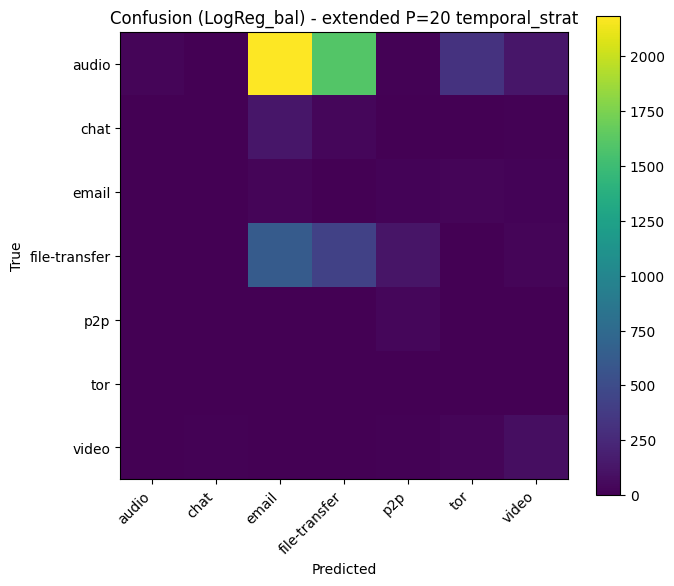

In [13]:
P = CONFIG["P_default"]

X_base, y_str, ts = build_X_y_ts_from_samples(samples, sids, P=P, extended=False)
X_ext,  _,    _   = build_X_y_ts_from_samples(samples, sids, P=P, extended=True)

le = LabelEncoder()
y_enc = le.fit_transform(y_str)

idx = np.arange(len(y_enc))
tr_r, te_r = train_test_split(
    idx,
    test_size=CONFIG["test_frac"],
    random_state=SEED,
    stratify=y_enc
)

tr_t, te_t = stratified_temporal_split_idx(y_enc, ts, test_frac=CONFIG["test_frac"])

tbl = pd.concat([
    eval_table(X_base, y_enc, tr_r, te_r, f"baseline P={P} / random"),
    eval_table(X_base, y_enc, tr_t, te_t, f"baseline P={P} / temporal_strat"),
    eval_table(X_ext,  y_enc, tr_r, te_r, f"extended P={P} / random"),
    eval_table(X_ext,  y_enc, tr_t, te_t, f"extended P={P} / temporal_strat"),
], ignore_index=True)

display(tbl)

# Confusion matrix for best temporal+extended
best_row = (
    tbl[tbl["setting"].str.contains("extended") & tbl["setting"].str.contains("temporal_strat")]
    .sort_values("balanced_accuracy", ascending=False)
    .iloc[0]
)
best_model_name = best_row["model"]
print("Best temporal+extended:", best_row.to_dict())

model = models[best_model_name]
model.fit(X_ext[tr_t], y_enc[tr_t])
pred = model.predict(X_ext[te_t])

plot_confusion(
    y_true=y_enc[te_t],
    y_pred=pred,
    class_names=list(le.classes_),
    title=f"Confusion ({best_model_name}) - extended P={P} temporal_strat"
)

### Interpretation (high level)
- Extended features consistently improve performance over baseline.
- Temporal stratified splits are harder (as expected), indicating time drift and reduced leakage.
- Performance saturates quickly with P: most discriminative signal is present in early packets.

## 8. Ablation: how many packets per sample?

We vary P ∈ {5, 10, 20, 40} and compute best balanced accuracy across models for each:
- baseline vs extended
- random vs temporal stratified split

This answers: **How many packets are needed before performance saturates?**


In [14]:
records = []
P_list = CONFIG["P_list"]

for P in P_list:
    Xb, y_str, ts = build_X_y_ts_from_samples(samples, sids, P=P, extended=False)
    Xe, _, _      = build_X_y_ts_from_samples(samples, sids, P=P, extended=True)

    leP = LabelEncoder()
    y_enc = leP.fit_transform(y_str)

    idx = np.arange(len(y_enc))
    tr_r, te_r = train_test_split(
        idx,
        test_size=CONFIG["test_frac"],
        random_state=SEED,
        stratify=y_enc
    )
    tr_t, te_t = stratified_temporal_split_idx(y_enc, ts, test_frac=CONFIG["test_frac"])

    for feat_name, X in [("baseline", Xb), ("extended", Xe)]:
        for split_name, (tr, te) in [("random", (tr_r, te_r)), ("temporal_strat", (tr_t, te_t))]:
            for mname, model in models.items():
                model.fit(X[tr], y_enc[tr])
                pred = model.predict(X[te])
                records.append({
                    "P": P, "features": feat_name, "split": split_name, "model": mname,
                    "balanced_accuracy": float(balanced_accuracy_score(y_enc[te], pred)),
                    "macro_f1": float(f1_score(y_enc[te], pred, average="macro")),
                })

df_ab = pd.DataFrame(records)
display(
    df_ab.sort_values(["split","features","P","balanced_accuracy"], ascending=[True,True,True,False]).head(30)
)

,P,features,split,model,balanced_accuracy,macro_f1
1,5,baseline,random,RF,0.385258,0.415779
2,5,baseline,random,ExtraTrees,0.382977,0.408648
0,5,baseline,random,LogReg_bal,0.300869,0.148376
13,10,baseline,random,RF,0.390256,0.423757
12,10,baseline,random,LogReg_bal,0.385977,0.160695
14,10,baseline,random,ExtraTrees,0.384693,0.416887
25,20,baseline,random,RF,0.388185,0.426193
24,20,baseline,random,LogReg_bal,0.387463,0.179617
26,20,baseline,random,ExtraTrees,0.373542,0.410465
36,40,baseline,random,LogReg_bal,0.385767,0.183968


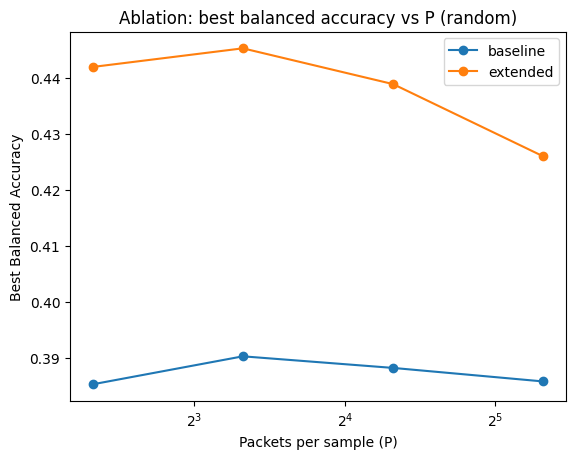

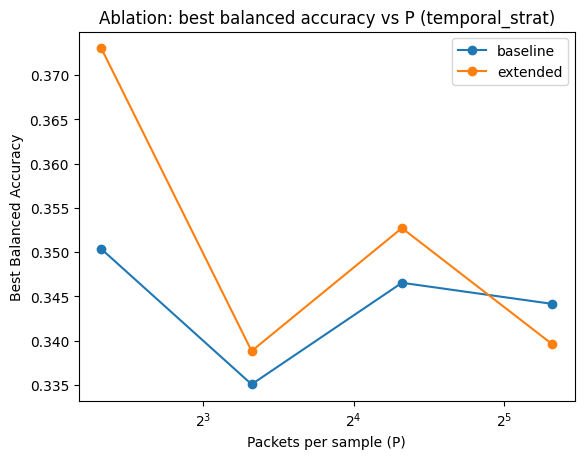

In [15]:
best = df_ab.groupby(["P","features","split"])["balanced_accuracy"].max().reset_index()

for split in ["random", "temporal_strat"]:
    plt.figure()
    for feat in ["baseline", "extended"]:
        sub = best[(best["split"] == split) & (best["features"] == feat)]
        plt.plot(sub["P"], sub["balanced_accuracy"], marker="o", label=feat)
    plt.xscale("log", base=2)
    plt.xlabel("Packets per sample (P)")
    plt.ylabel("Best Balanced Accuracy")
    plt.title(f"Ablation: best balanced accuracy vs P ({split})")
    plt.legend()
    plt.show()

### Interpretation
- Best performance occurs at modest P (typically 10–20).
- Larger P can degrade performance due to added noise / higher dimensionality.
- Under temporal evaluation, smaller P can generalize better (less overfit to time-specific behavior).

## 9. Saving artifacts

We save:
- `results/leaderboard.csv`: main comparison table
- `results/ablation.csv`: full ablation record
These files can be used directly in the Sphinx report.


In [16]:
os.makedirs("results", exist_ok=True)

tbl.to_csv("results/leaderboard.csv", index=False)
df_ab.to_csv("results/ablation.csv", index=False)

print("Saved:")
print(" - results/leaderboard.csv")
print(" - results/ablation.csv")

import platform
print("Python:", platform.python_version())
print("Platform:", platform.platform())

# optional: pip freeze (can be long)
# !pip freeze | head -n 50

Saved:
 - results/leaderboard.csv
 - results/ablation.csv
Python: 3.10.18
Platform: macOS-14.5-x86_64-i386-64bit


## Limitations and next steps

- Direction is inferred using the first seen source address per sample; this is a heuristic.
- Temporal split is per-class; it preserves labels but is not a full streaming evaluation.
- Future improvements:
  - try calibration + confidence
  - measure compute cost vs accuracy (feature + training time)
  - evaluate transfer: train on one capture time period, test on another capture